In [123]:
## Josh Blaz -- LOTR
import nltk
import re
import urllib.request
import lxml.html as lh
import io
import requests
import os
import glob
from ggplot import *

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#NOTE: Sentiment140 Polarity values: 0: negative, 2: neutral, 4: positive

**NOTE: Elvish text is translated awkwardly into the .txt format    
</br>
IE:   
</br>
►M MPR -F+MTRX MP ft PPtK P&RMPht: P. t. The last Two runes are the initials of Thror and Thrain.**

In [36]:
# Used Chapterize to split books into chapters 
## https://github.com/JonathanReeve/chapterize
### Chapterize didn't work 100% perfectly, so I had to go through and the prologues back in when it cut them out

# These are lists containing strings of every chapter for each book
silm_chapters = []
hobbit_chapters = []
fellowship_chapters = []
twotowers_chapters = []
return_chapters = []

# Paths to directories storing book chapters
list_of_paths = ['/Users/blaz/Desktop/LOTR/silmarillion-chapters', '/Users/blaz/Desktop/LOTR/hobbit-chapters',\
                '/Users/blaz/Desktop/LOTR/fellowship-chapters', '/Users/blaz/Desktop/LOTR/twotowers-chapters',\
                '/Users/blaz/Desktop/LOTR/return-chapters']

for path in list_of_paths: # iterate through the list of folder paths for each book
    for file in sorted(glob.glob(os.path.join(path,'*.txt'))): # This gives us a sorted list of the files in each directory                                                         
        f = open(file, 'r') # open and read file               # allowing us to read in the chapters in order.
        txt = f.read()
        ## determine which path we're using and append it to the correct book chapter list
        if path == '/Users/blaz/Desktop/LOTR/silmarillion-chapters': 
            # Because of an issue with 'glob', I had to create a copy of the final chapter in The Silmarillion
            silm_chapters.append(txt)
        elif path == '/Users/blaz/Desktop/LOTR/hobbit-chapters':
            hobbit_chapters.append(txt)
        elif path == '/Users/blaz/Desktop/LOTR/fellowship-chapters': 
            fellowship_chapters.append(txt)
        elif path == '/Users/blaz/Desktop/LOTR/twotowers-chapters': 
            twotowers_chapters.append(txt)
        elif path == '/Users/blaz/Desktop/LOTR/return-chapters': 
            return_chapters.append(txt)

In [37]:
# Store chapter names for use in dataframes later

silm_chapter_names = ["Ainundalë", "Valaquenta", "Of the Beginning of Days", "Of Aulë and Yavanna" , "Of the Coming of the Elves and the Captivity of Melkor",\
                     "Of Thingol and Melian", "Of Eldamar and the Princes of the Eldalië", "Of Fëanor and the Unchaining of Melkor", "Of the Silmarils and the Unrest of the Noldor",\
                     "Of the Darkening of Valinor", "Of the Flight of the Noldor", "Of the Sindar", "Of the Sun and Moon and the Hiding of Valinor", "Of Men", "Of the Return of the Noldor",\
                     "Of Beleriad and its Realms", "Of the Noldor in Beleriad", "Of Maeglin", "Of the Coming of Men into the West", "Of the Ruin of Beleriad and the Fall of Fingolfin", "Of Beren and Lúthien",\
                     "Of the Fifth Battle: Nirnaeth Arnoediad", "Of Túrin Turambar", "Of the Ruin of Doriath", "Of Tuor and the Fall of Gondolin", "Of the Voyage of Eärendil and the War of Wrath", \
                     "Akallabêth: The Downfall of Númenor", "Of the Rings of Power and the Third Age"]

hobbit_chapter_names = ["An Unexpected Party", "Roast Mutton", "A Short Rest", "Over Hill and Under Hill", "Riddles In The Dark", \
                       "Out Of The Frying-Pan Into The Fire", "Queer Lodgings", "Flies And Spiders", "Barrels Out Of Bond", "A Warm Welcome", \
                       "On The Doorstep", "Inside Information", "Not At Home", "Fire And Water", "The Gathering Of The Clouds", "A Thief In The Night", \
                       "The Clouds Burst", "The Return Journey", "The Last Stage"]

fellowship_chapter_names = ["Concerning Hobbits", "Concerning Pipeweed", "Of the Ordering of the Shire", "Note on the Shire Records", "A Long-expected Party", "The Shadow of the Past", \
                           "Three is Company", "A Short Cut to Mushrooms", "A Conspiracy Unmasked", "The Old Forest", "In the House of Tom Bombadil", "Fog on the Barrow-downs", "At the Sign of the Prancing Pony",\
                           "Strider", "A Knife in the Dark", "Flight to the Ford", "Many Meetings", "The Council of Elrond", "The Ring goes South", "A Journey in the Dark", "The Bridge of Khazad-dûm", \
                           "Lothlórien", "The Mirror of Galadriel", "Farewell to Lórien", "The Great River", "The Breaking of the Fellowship"]

twotowers_chapter_names = ["The Departure of Boromir", "The Riders of Rohan", "The Uruk-hai", "Treebeard", "The White Rider", "The King of the Golden Hall", "Helm's Deep", "The Road to Isengard", "Flotsam and Jetsam", \
                          "The Voice of Saruman", "The Palantír", "The Taming of Smeagol", "The Passage of the Marshes", "The Black Gate is Closed", "Of Herbs and Stewed Rabbit", "The Window of the West", "The Forbidden Pool", \
                          "Journey to the Cross-roads", "The Stairs to Cirith Ungol", "Shelob's Lair", "The Choices of Master Samwise"]

return_chapter_names = ["Minas Tirith", "The Passing of the Grey Company", "The Muster of Rohan", "The Siege of Gondor", "The Ride of Rohirrim", "The Battle of the Pelennor Fields", "The Pyre of Denethor",\
                       "The Houses of Healing", "The Last Debate", "The Black Gate Opens", "The Tower of Cirith Ungol", "The Land of Shadow", "Mount Doom", "The Field of Cormallen", "The Steward and the King", \
                       "Many Partings", "Homeward Bound", "Scouring of the Shire", "The Grey Havens"]


# Sentiment Analysis

**Now, for each book, we have lists containing all of the chapters for that book.  
</br>
This was accomplished by iterating through the directories that store the chapters for each book using the "glob" and "os" modules.**

In [38]:
"""
Function that segments given chapter into a page-sized (2940 character) segments to be sent to the API.

Parameters - chapter - chapter of a book to be broken into segments
           - cut - length that we segment the text with
       
Returns a list of (string) segments of the chapter.
"""
def Segmenter(chapter, cut):
    segments = []
    # start and end indices for segmenting the text
    start = 0
    end = cut
    while end < len(chapter) + cut:
        segments.append(chapter[start:end])
        start = end
        end = end + cut
    return segments #segments of input chapter

**This function allows us to split the chapters of each book into segments to send in our HTTP-Post JSON requests.   
</br>
I chose 2940 as the length because this is the exact number of characters per page (including spaces) in my copy of Fellowship of the Ring. **

In [52]:
# Lists of Lists of Lists storing all segments of all chapters for each book
# [[chapter1 segment 0-2500, chap1, segmenet 2500-5000]... [chapter2 segment0-2500, ...]...]
silm_segments = []
hobbit_segments = []
fellowship_segments = []
twotowers_segments = []
return_segments = []

# List containing the lists storing each books' chapters
list_of_books = [silm_chapters, hobbit_chapters, fellowship_chapters, twotowers_chapters, return_chapters]
# List allowing us to access the segment lists
list_of_segments = [silm_segments, hobbit_segments, fellowship_segments, twotowers_segments, return_segments]

# Access the lists above so that we can iteratively segment each chapter in the corpus
for i in range(len(list_of_books)):
    for chapter in list_of_books[i]:
        list_of_segments[i].append(Segmenter(chapter,2940))


**In the cell above I create lists of lists for segments of each chapter of each corpus or book, and append to them using my "Segmenter"
function, storing them neatly like this will allow me to iteratively query the API server. **

In [40]:
"""
Function that sends segments of 1 chapter through the Sentiment140 API.
In order to do so, it creates and appends segments to a JSON file, then posts the JSON queries to the API server
using requests module (using an HTTP Post)

Parameters - chapter_segments - segments of an entire chapter of a book

Returns a list of polarities for segments of the chapter, as well as the polarity average for the chapter

Note: Maximum of 700,000 characters per API request, though this shouldn't be a problem
"""

def Polarity(chapter_segments): # segments of a single chapter
    request = {'data':[]}
    polarityList = []
    counter = 0
    for segment in chapter_segments: # Fill JSON
        request['data'].append({'text':segment})
    r = requests.post('http://www.sentiment140.com/api/bulkClassifyJson?appid=blaz_j1@denison.edu', json=request)
    jso = r.json()
    for i in range(len(request['data'])-1):
        polarityList.append(jso['data'][i]['polarity'])
    
    polarityTotal = 0
    for value in polarityList:
        polarityTotal = polarityTotal + value
    
    polarityAVG = polarityTotal/len(polarityList)
    #print(polarityList)
    return polarityList, polarityAVG

In [41]:
# This function takes about a minute to run

# store all averages, then store chapter avg, also overall average
silm_polarity_avg = []
hobbit_polarity_avg = []
fellowship_polarity_avg = []
twotowers_polarity_avg = []
return_polarity_avg = []

silm_polarity_lists = []
hobbit_polarity_lists = []
fellowship_polarity_lists = []
twotowers_polarity_lists = []
return_polarity_lists = []
### Need to get chapter names in

for x in range(len(list_of_books)):
    book = list_of_books[x]
    segs = list_of_segments[x]
    
    if x == 0:
        print("silm")
    if x == 1:
        print("hobbit")
    if x == 2:
        print("fellowship")
    if x == 3:
        print("two towers")
    if x == 4:
        print("return of the king")
    
    for i in range(len(book)):
        if x == 0:
            temp1 = []
            temp2 = 0.0
            temp1,temp2 = Polarity(segs[i])
            silm_polarity_lists.append(temp1)
            silm_polarity_avg.append(temp2)
        if x == 1:
            temp1 = []
            temp2 = 0.0
            temp1,temp2 = Polarity(segs[i])
            hobbit_polarity_lists.append(temp1)
            hobbit_polarity_avg.append(temp2)
        if x == 2:
            temp1 = []
            temp2 = 0.0
            temp1,temp2 = Polarity(segs[i])
            fellowship_polarity_lists.append(temp1)
            fellowship_polarity_avg.append(temp2)
        if x == 3:
            temp1 = []
            temp2 = 0.0
            temp1,temp2 = Polarity(segs[i])
            twotowers_polarity_lists.append(temp1)
            twotowers_polarity_avg.append(temp2)
        if x == 4:
            temp1 = []
            temp2 = 0.0
            temp1,temp2 = Polarity(segs[i])
            return_polarity_lists.append(temp1)
            return_polarity_avg.append(temp2)

all_polarity_avgs = [silm_polarity_avg, hobbit_polarity_avg, fellowship_polarity_avg, twotowers_polarity_avg, return_polarity_avg]

all_polarity_lists = [silm_polarity_lists, hobbit_polarity_lists, fellowship_polarity_lists, twotowers_polarity_lists, return_polarity_lists]  
# chapter 3 of return of the king is super dark

silm
hobbit
fellowship
two towers
return of the king


In [121]:
for x in range(len(all_polarity_avgs)):
    if x == 0:
        print("")
        print("SILM:")
        print(silm_chapter_names)
        print(all_polarity_avgs[x])
    if x == 1:
        print("")
        print("HOBBIT")
        print(hobbit_chapter_names)
        print(all_polarity_avgs[x])
    if x == 2:
        print("")
        print("FELLOWSHIP")
        print(fellowship_chapter_names)
        print(all_polarity_avgs[x])
    if x == 3:
        print("")
        print("TWO TOWERS")
        print(twotowers_chapter_names)
        print(all_polarity_avgs[x])
    if x == 4:
        print("")
        print("RETURN OF THE KING")
        print(return_chapter_names)
        print(all_polarity_avgs[x])
        


SILM:
['Ainundalë', 'Valaquenta', 'Of the Beginning of Days', 'Of Aulë and Yavanna', 'Of the Coming of the Elves and the Captivity of Melkor', 'Of Thingol and Melian', 'Of Eldamar and the Princes of the Eldalië', 'Of Fëanor and the Unchaining of Melkor', 'Of the Silmarils and the Unrest of the Noldor', 'Of the Darkening of Valinor', 'Of the Flight of the Noldor', 'Of the Sindar', 'Of the Sun and Moon and the Hiding of Valinor', 'Of Men', 'Of the Return of the Noldor', 'Of Beleriad and its Realms', 'Of the Noldor in Beleriad', 'Of Maeglin', 'Of the Coming of Men into the West', 'Of the Ruin of Beleriad and the Fall of Fingolfin', 'Of Beren and Lúthien', 'Of the Fifth Battle: Nirnaeth Arnoediad', 'Of Túrin Turambar', 'Of the Ruin of Doriath', 'Of Tuor and the Fall of Gondolin', 'Of the Voyage of Eärendil and the War of Wrath', 'Akallabêth: The Downfall of Númenor', 'Of the Rings of Power and the Third Age']
[1.6666666666666667, 3.3333333333333335, 2.857142857142857, 2.6666666666666665, 

In [130]:
# Converting AVG data into pandas dataframes

silm_df = pd.DataFrame(silm_polarity_avg, index = silm_chapter_names, columns = ["Polarity"])
silm_df = silm_df.rename_axis("--- The Silmarillion ---")
#silm_df.to_csv("silm_df.csv")

hobbit_df = pd.DataFrame(hobbit_polarity_avg, index = hobbit_chapter_names, columns = ["Polarity"])
hobbit_df = hobbit_df.rename_axis("--- The Hobbit ---")
#hobbit_df.to_csv("hobbit_df.csv")

fellowship_df = pd.DataFrame(fellowship_polarity_avg, index = fellowship_chapter_names, columns = ["Polarity"])
fellowship_df = fellowship_df.rename_axis("--- The Fellowship of the Ring ---")
# Prologue chapters have weird polarities - have solid values because they're shorter
#fellowship_df.to_csv("fellowship_df.csv")

twotowers_df = pd.DataFrame(twotowers_polarity_avg, index = twotowers_chapter_names, columns = ["Polarity"])
twotowers_df = twotowers_df.rename_axis("--- The Two Towers ---")
#twotowers_df.to_csv("twotowers_df.csv")

return_df = pd.DataFrame(return_polarity_avg, index = return_chapter_names, columns = ["Polarity"])
return_df = return_df.rename_axis("--- The Return of the King ---")
#return_df.to_csv("return_df.csv")
# Really dark novel

# Dataframe of all Books overlaid
books_df = [silm_df, hobbit_df, fellowship_df, twotowers_df, return_df]
#full_df = pd.concat(books_df)

# Export to CSV
#full_df.to_csv("full_df.csv")

"""
# Export to Excel
pd.read_excel('file.xlsx')
full_df.to_csv("full_df.csv")
pd.to_excel('dir/myDataFrame.xlsx', sheet_name='Sheet1')
"""

# Add another column for topic, once topic modeling is complete


## NEXT: save polarity lists to dataframes to show how some books are darker than others

'\n# Export to Excel\npd.read_excel(\'file.xlsx\')\nfull_df.to_csv("full_df.csv")\npd.to_excel(\'dir/myDataFrame.xlsx\', sheet_name=\'Sheet1\')\n'

In [131]:
print(silm_df)

                                                    Polarity
--- The Silmarillion ---                                    
Ainundalë                                           1.666667
Valaquenta                                          3.333333
Of the Beginning of Days                            2.857143
Of Aulë and Yavanna                                 2.666667
Of the Coming of the Elves and the Captivity of...  2.285714
Of Thingol and Melian                               4.000000
Of Eldamar and the Princes of the Eldalië           2.000000
Of Fëanor and the Unchaining of Melkor              2.666667
Of the Silmarils and the Unrest of the Noldor       1.600000
Of the Darkening of Valinor                         1.333333
Of the Flight of the Noldor                         0.727273
Of the Sindar                                       2.400000
Of the Sun and Moon and the Hiding of Valinor       2.000000
Of Men                                              2.000000
Of the Return of the Nol

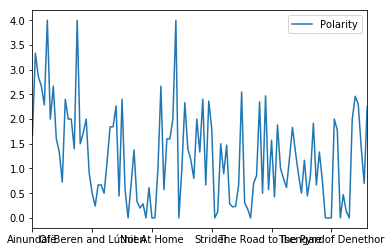

In [120]:
# Plots
## Note: Wasn't able to get another Tableau Trial

from matplotlib.pyplot import figure


"""
## lol
full_df.plot(kind='bar')
plt.show()
"""

full_df.plot(kind='line')
plt.show()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)


# Topic Modeling

# Testing

In [350]:
### Example JSON request
#NOTE: Sentiment140 Polarity values: 0: negative, 2: neutral, 4: positive

d = {'data':[{'text':'the titanic was ok'}, {'text':'this sucks'}]}
d['data'].append({'text':"Happy day!"})

r = requests.post('http://www.sentiment140.com/api/bulkClassifyJson?appid=blaz_j1@denison.edu', json=d)
js = r.json()

print(js['data'])

[{'text': 'the titanic was ok', 'polarity': 2, 'meta': {'language': 'en'}}, {'text': 'this sucks', 'polarity': 0, 'meta': {'language': 'en'}}, {'text': 'Happy day!', 'polarity': 4, 'meta': {'language': 'en'}}]


In [351]:
### Example of accessing the polarities

for i in range(len(d['data'])):
    print("Text:", js['data'][i]['text'], "\nPolarity:", js['data'][i]['polarity'])

Text: the titanic was ok 
Polarity: 2
Text: this sucks 
Polarity: 0
Text: Happy day! 
Polarity: 4


In [43]:
## Segment list indexing examples

#print(hobbit_segments[15]) ## -- chapter
#print(hobbit_segments[0][0]) ## -- segments of chapter

In [ ]:
#Working with 'glob'

path= '/Users/blaz/Desktop/LOTR/silmarillion-chapters'
silm_chapters = []

for file in sorted(glob.glob(os.path.join(path,'*.txt'))):
    print(file)
    f = open(file, 'r')
    txt = f.read()
    silm_chapters.append(txt)
    
print(len(silm_chapters))
print(silm_chapters[len(silm_chapters)-1])